<a href="https://colab.research.google.com/github/PLippmann/disaster-tweet-jax/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disaster Tweet Kaggle Competition in Jax

This solves the [Disaster Tweet Kaggle Competition](https://www.kaggle.com/c/nlp-getting-started) using a standard BERT approach using Jax.

There are very few available approaches to problems like this using Jax, so I thought I would share mine.

It will get you an eval score on the hidden test set of around 0.836, placing you close to the top of the rolling leaderboard. I'm sure that you can push this further if you optimize hypers, clean the training text, and choose a more capable model.

This implementation also trains fast (~3 mins on TPU), compared to unoptimized versions you might use, due to the use of JIT.

## Install and import relevant packages. Check for TPU.

In [ ]:
!pip install -q transformers datasets jax jaxlib optax flax
!pip install -q pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import jax
import jax.numpy as jnp
from transformers import AutoTokenizer, FlaxAutoModelForSequenceClassification

print(jax.local_device_count())
print(jax.devices())

8
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


## Load the local data and print some information to sanity check.

In [ ]:
# Load the dataset
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain columns:", train_df.columns)
print("Test columns:", test_df.columns)

print("\nSample from train_df:")
print(train_df.head())

Train shape: (7613, 5)
Test shape: (3263, 4)

Train columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Test columns: Index(['id', 'keyword', 'location', 'text'], dtype='object')

Sample from train_df:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## Visualize the data. Here, we show the class distribution, plot the length, and show the top keywords.

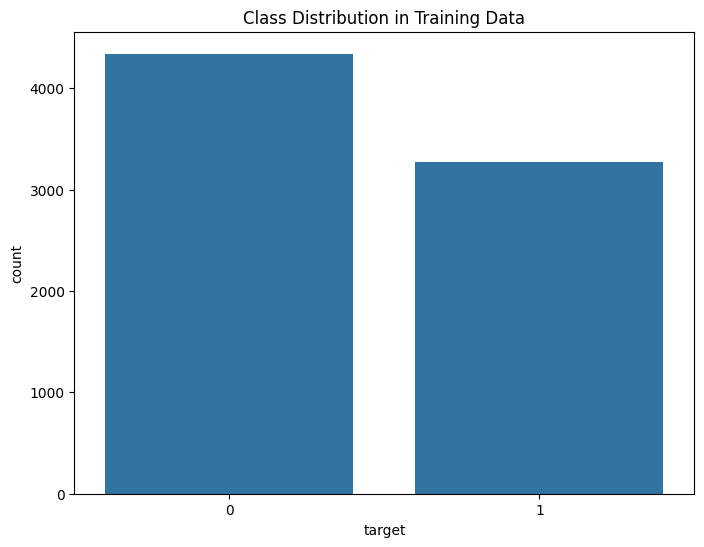

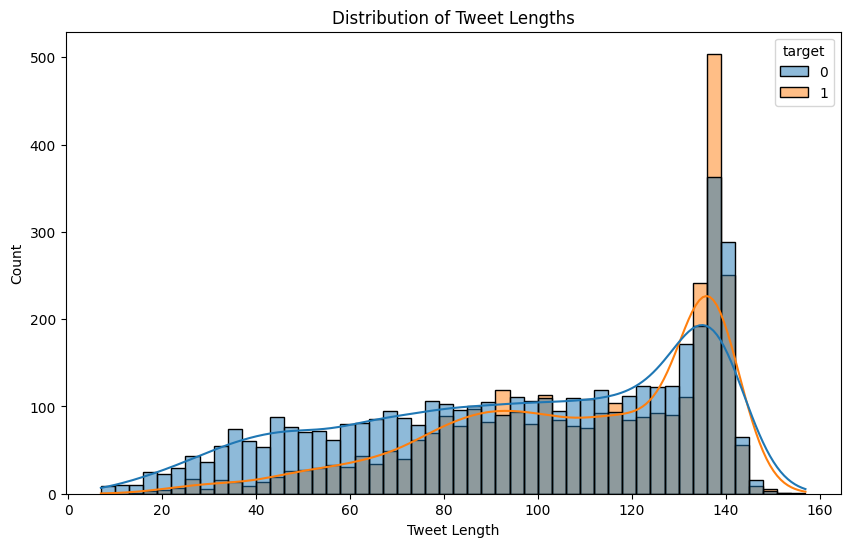

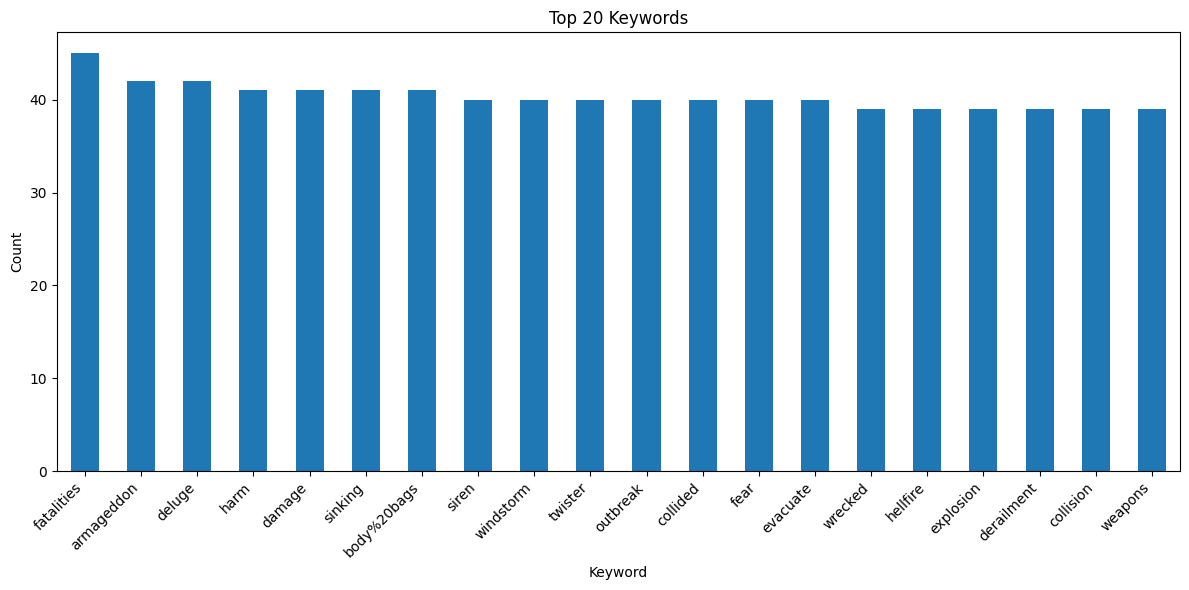

In [ ]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution in Training Data')
plt.show()

# Visualize tweet lengths
train_df['tweet_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='tweet_length', hue='target', bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.show()

# Visualize most common keywords
plt.figure(figsize=(12, 6))
train_df['keyword'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocess the data to generate a train and validation split.

In [ ]:
# Remove rows with missing values
train_df = train_df.dropna(subset=['text'])

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['target'].tolist(),
    test_size=0.1,
    random_state=42
)


## Define the model and load tokenizer from HF. Then we encode the different datasets.

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_df['text'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Set the config used to train the model, as well as the hypers.

In [ ]:
import optax
from flax.training import train_state


# Load the model configuration
config = AutoConfig.from_pretrained(model_name)

# Set the desired dropout rate
config.hidden_dropout_prob = 0.1  # Dropout for hidden layers
config.attention_probs_dropout_prob = 0.1  # Dropout for attention layers
config.num_labels = 2  # Set the number of labels for the classification task

# Load the model with the modified config
model = FlaxAutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Define the learning rate and optimizer
learning_rate = 5e-6
optimizer = optax.adamw(learning_rate=learning_rate, weight_decay=1e-5) # Weight decay helped with overfitting

# Initialize model parameters
rng = jax.random.PRNGKey(42)
input_shape = (1, 128)
inputs = {"input_ids": jnp.ones(input_shape, dtype="i4")}
params = model.params

# Create train state for Jax
class TrainState(train_state.TrainState):
    logits_fn: callable = None

state = TrainState.create(
    apply_fn=model.__call__,
    params=params,
    tx=optimizer,
)

print("Model initialized and ready for training.")

Some weights of the model checkpoint at roberta-base were not used when initializing FlaxRobertaForSequenceClassification: {('lm_head', 'layer_norm', 'bias'), ('lm_head', 'layer_norm', 'scale'), ('lm_head', 'dense', 'bias'), ('lm_head', 'dense', 'kernel'), ('lm_head', 'bias')}
- This IS expected if you are initializing FlaxRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaxRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: {('classifier', 'dense', 'kernel'), ('classifier', 'out_proj', 'kernel')

Model initialized and ready for training.


## Data loader that moves trainig and val data to device.

In [ ]:
import numpy as np


def create_train_dataset():
    dataset = {
        'input_ids': np.array(train_encodings['input_ids']),
        'attention_mask': np.array(train_encodings['attention_mask']),
        'labels': np.array(train_labels)
    }
    return dataset

def create_val_dataset():
    dataset = {
        'input_ids': np.array(val_encodings['input_ids']),
        'attention_mask': np.array(val_encodings['attention_mask']),
        'labels': np.array(val_labels)
    }
    return dataset

train_dataset = create_train_dataset()
val_dataset = create_val_dataset()

def data_loader(dataset, batch_size, shuffle=False):
    num_samples = len(dataset['input_ids'])
    indices = np.arange(num_samples)

    # Shuffle indices if required
    if shuffle:
        np.random.shuffle(indices)

    # Yield batches
    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i+batch_size]

        # Collect batch and move it to the TPU memory using jax.device_put
        batch = {k: jnp.array(v[batch_indices]) for k, v in dataset.items()}
        batch_on_device = jax.device_put(batch)

        yield batch_on_device

## Core training and eval loops. In JIT.

In [ ]:
@jax.jit
def train_step(state, batch, dropout_key):
    def loss_fn(params):
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        params=params,
                        train=True,
                        dropout_rng=dropout_key)
        logits = outputs.logits
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, batch['labels']).mean()
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch['labels'])
    return state, loss, accuracy

@jax.jit
def eval_step(state, batch):
    outputs = model(input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    params=state.params,
                    train=False)
    logits = outputs.logits
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, batch['labels']).mean()
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch['labels'])
    return loss, accuracy

## Here is where we perform the actual training for a given number of epochs and a certain batch size. The model is evaluated on the validation set at each epoch.


In [ ]:
from tqdm.notebook import tqdm


key = jax.random.PRNGKey(0)

num_epochs = 5
batch_size = 32

for epoch in range(num_epochs):
    # Training
    total_loss, total_accuracy = 0, 0
    num_batches = 0
    # Split PRNG key for each batch
    key, epoch_key = jax.random.split(key)

    for batch in tqdm(data_loader(train_dataset, batch_size, shuffle=True), desc=f"Epoch {epoch + 1} Training"):
        # Split PRNG key for dropout
        epoch_key, dropout_key = jax.random.split(epoch_key)

        # Training step
        state, loss, accuracy = train_step(state, batch, dropout_key)
        total_loss += loss
        total_accuracy += accuracy
        num_batches += 1

    avg_train_loss = total_loss / num_batches
    avg_train_accuracy = total_accuracy / num_batches

    # Evaluation
    total_loss, total_accuracy = 0, 0
    num_batches = 0
    for batch in data_loader(val_dataset, batch_size):
        # Evaluation step
        loss, accuracy = eval_step(state, batch)
        total_loss += loss
        total_accuracy += accuracy
        num_batches += 1

    avg_val_loss = total_loss / num_batches
    avg_val_accuracy = total_accuracy / num_batches

    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
    print()

print("Training completed!")

Epoch 1 Training: 0it [00:00, ?it/s]

Epoch 1
Train Loss: 0.4999, Train Accuracy: 0.7455
Val Loss: 0.3954, Val Accuracy: 0.8383



Epoch 2 Training: 0it [00:00, ?it/s]

Epoch 2
Train Loss: 0.3704, Train Accuracy: 0.8446
Val Loss: 0.3952, Val Accuracy: 0.8344



Epoch 3 Training: 0it [00:00, ?it/s]

Epoch 3
Train Loss: 0.3334, Train Accuracy: 0.8630
Val Loss: 0.4122, Val Accuracy: 0.8302



Epoch 4 Training: 0it [00:00, ?it/s]

Epoch 4
Train Loss: 0.3032, Train Accuracy: 0.8791
Val Loss: 0.4634, Val Accuracy: 0.8127



Epoch 5 Training: 0it [00:00, ?it/s]

Epoch 5
Train Loss: 0.2645, Train Accuracy: 0.8972
Val Loss: 0.4115, Val Accuracy: 0.8393

Training completed!


## Save the model. Can use the code below to load a saved checkpoint as well.

In [ ]:
'''
# Uncomment to save and/or load model checkpoints
from transformers import FlaxAutoModelForSequenceClassification, AutoTokenizer
from flax.training import checkpoints

# Save the fine-tuned model
model_save_path = "/content/fine_tuned_disaster_tweets_model"
checkpoints.save_checkpoint(model_save_path, state, step=num_epochs, keep=1)
print(f"Model saved to {model_save_path}")

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)
print(f"Tokenizer saved to {model_save_path}")

# Load the tokenizer
loaded_tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_disaster_tweets_model")

# Load the model
loaded_model = FlaxAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
loaded_state = checkpoints.restore_checkpoint("./fine_tuned_disaster_tweets_model", target=None)
'''

SyntaxError: incomplete input (<ipython-input-12-b5be01400e98>, line 1)

## Perform inference on the test set to generate predictions for submission.

In [ ]:
# Same as before but now for the test set
def create_test_dataset():
    dataset = {
        'input_ids': np.array(test_encodings['input_ids']),
        'attention_mask': np.array(test_encodings['attention_mask']),
    }
    return dataset

test_dataset = create_test_dataset()

# Function to perform inference on the test dataset
@jax.jit
def predict_step(state, batch):
    outputs = model(input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    params=state.params,
                    train=False)
    logits = outputs.logits
    return logits

# Perform predictions on the test dataset
predictions = []
batch_size = 32

for batch in data_loader(test_dataset, batch_size):
    logits = predict_step(state, batch)
    predictions.append(logits)

# Concatenate logits and apply softmax to get probabilities
all_logits = jnp.concatenate(predictions, axis=0)
probabilities = jax.nn.softmax(all_logits, axis=-1)

# Get the predicted labels
predicted_classes = jnp.argmax(probabilities, axis=-1)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Ensure 'id' matches your test CSV structure
    'target': predicted_classes
})

# Save the submission DataFrame to a CSV file
submission_file_path = '/content/submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file created at: {submission_file_path}")


Submission file created at: /content/submission.csv
